# UW Madison GI Tract Image Segmentation
EDA

# 📚 Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# 📀 Meta Data

Files
- train.csv: IDs and masks for all training data
- sample_submission.csv: a sample submission
- train - a folder of case/day folders, each containing slice images for a particular case on a given day.

> 파일 이름이 4개의 숫자로 이뤄진다. 예를 들어 `276_276_1.63_1.63.png`. 
각 숫자는 1)높이, 2)너비, 3)높이/4)너비 pixel spacing으로 이뤄져있다. 

In [2]:
BASE_PATH = "../input/uw-madison-gi-tract-image-segmentation"

In [3]:
df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


대부분의 행이 segmentation 정보가 없음을 확인 할 수 있다.

## preprocessing

`id` 열 로부터 id의 정보를 추출하며 `segmentation` 열을 `str`로 변환할 것이다.

In [5]:
df['case_id'] = df['id'].apply(lambda x: x.split('_')[0][4:])
df['day_id'] = df['id'].apply(lambda x: x.split('_')[1][3:])
df['slice'] = df['id'].apply(lambda x: x.split('_')[-1])
df['segmentation'] = df['segmentation'].astype('str')
df.head()

,id,class,segmentation,case_id,day_id,slice
0,case123_day20_slice_0001,large_bowel,nan,123,20,0001
1,case123_day20_slice_0001,small_bowel,nan,123,20,0001
2,case123_day20_slice_0001,stomach,nan,123,20,0001
3,case123_day20_slice_0002,large_bowel,nan,123,20,0002
4,case123_day20_slice_0002,small_bowel,nan,123,20,0002


그리고나서 `id` 열로부터 데이터 위치를 추출하자  
실제 데이터 경로 예시는 다음과 같다  
`../input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png`

In [6]:
def fetch_path_from_id(base_path, case_id):
    case_folder = case_id.split('_')[0]
    day_folder = '_'.join(case_id.split('_')[:2])
    png_file_start = '_'.join(case_id.split('_')[2:])
    
    folder = os.path.join(base_path,'train', case_folder, day_folder, 'scans')
    png_file = glob(os.path.join(folder, png_file_start+"*"))[0]
    return png_file

tqdm.pandas(desc='Fetch path from id')
df['path'] = df['id'].progress_apply(lambda x: fetch_path_from_id(BASE_PATH, x))
df.head()
    

Fetch path from id: 100%|██████████| 115488/115488 [01:33<00:00, 1234.25it/s]


,id,class,segmentation,case_id,day_id,slice,path
0,case123_day20_slice_0001,large_bowel,nan,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0001,small_bowel,nan,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0001,stomach,nan,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0002,large_bowel,nan,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0002,small_bowel,nan,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...


이제는 마스크의 height, width, pixel spacing 정보를 찾아 붙이자

In [7]:
df['height'] = df['path'].apply(lambda x: x.split('/')[-1].split('_')[2]).astype('int')
df['width'] = df['path'].apply(lambda x: x.split('/')[-1].split('_')[3]).astype('int')
df['pixel_horizontal_spacing'] = df['path'].apply(lambda x: x.split('/')[-1].split('_')[4]).astype('float')
df['pixel_vertical_spacing'] = df['path'].apply(lambda x: x.split('/')[-1].split('_')[5].split('.')[0]).astype('float')
df.head()

,id,class,segmentation,case_id,day_id,slice,path,height,width,pixel_horizontal_spacing,pixel_vertical_spacing
0,case123_day20_slice_0001,large_bowel,nan,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.0
1,case123_day20_slice_0001,small_bowel,nan,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.0
2,case123_day20_slice_0001,stomach,nan,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.0
3,case123_day20_slice_0002,large_bowel,nan,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.0
4,case123_day20_slice_0002,small_bowel,nan,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.0


이제 rle로된 `segmentation` 열을 마스크 이미지로 생성해보자

In [8]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

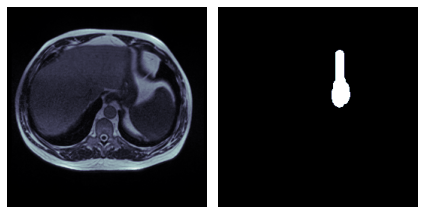

In [9]:
import cv2
plt.subplot(1,2,1); plt.axis('off')
plt.imshow(cv2.imread(df.loc[200, 'path'], cv2.IMREAD_UNCHANGED), cmap='bone')
plt.subplot(1,2,2); plt.axis('off')
plt.imshow(rle_decode(df.loc[200, 'segmentation'], df.loc[200, ['height', 'width']]), cmap='bone')
plt.tight_layout()
plt.show()